In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from python_classifier_2022.helper_code import * #codigo dado por el challenge
import os
%matplotlib inline


# Crear Base de Datos con los datos de los pacientes

En principio se tiene un excel con los datos demograficos de los pacientes con inforamción sobre los soplos, pero hay personas que participaron en años distintos de la adquision a los cuales tienen valores ectraños en el excel. Por ello se hace una base de datos propia

In [ ]:
path_train = '../DataBase/dataset-1.0.1/training_data/'
path_db = '../DataBase/dataset-1.0.1/'

In [ ]:
patient_files = find_patient_files(path_train)
len(patient_files)

942

In [ ]:
current_patient_data = load_patient_data(patient_files[1])

In [ ]:
current_patient_data

'2530 4 4000\nAV 2530_AV.hea 2530_AV.wav 2530_AV.tsv\nPV 2530_PV.hea 2530_PV.wav 2530_PV.tsv\nTV 2530_TV.hea 2530_TV.wav 2530_TV.tsv\nMV 2530_MV.hea 2530_MV.wav 2530_MV.tsv\n#Age: Child\n#Sex: Female\n#Height: 98.0\n#Weight: 15.9\n#Pregnancy status: False\n#Murmur: Absent\n#Murmur locations: nan\n#Most audible location: nan\n#Systolic murmur timing: nan\n#Systolic murmur shape: nan\n#Systolic murmur grading: nan\n#Systolic murmur pitch: nan\n#Systolic murmur quality: nan\n#Diastolic murmur timing: nan\n#Diastolic murmur shape: nan\n#Diastolic murmur grading: nan\n#Diastolic murmur pitch: nan\n#Diastolic murmur quality: nan\n#Campaign: CC2015\n#Additional ID: nan'

In [ ]:
def get_specific_info(data, search_str):
    label = None
    for l in data.split('\n'):
        if l.startswith(search_str):
            try:
                label = l.split(': ')[1]
            except:
                pass
    if label is None:
        raise ValueError('error when searching for more info')
    return label


In [ ]:
info='''#Age,
#Sex,
#Height,
#Weight,
#Pregnancy status,
#Murmur locations,
#Most audible location,
#Systolic murmur timing,
#Systolic murmur shape,
#Systolic murmur grading,
#Systolic murmur pitch,
#Systolic murmur quality,
#Diastolic murmur timing,
#Diastolic murmur shape,
#Diastolic murmur grading,
#Diastolic murmur pitch,
#Diastolic murmur quality,
#Campaign'''.split(',\n')

def get_patient_info(data):
    id = get_patient_id(data)
    num_loc = get_num_locations(data)
    locations = get_locations(data)
    frec = get_frequency(data)
    info_v=[]
    label = get_label(data)
    for i in info:
        info_v.append(get_specific_info(data,i))
    return np.hstack((id,info_v,frec,num_loc,'+'.join(locations),label))

In [ ]:
get_patient_info(current_patient_data)

array(['9979', 'Child', 'Female', '103.0', '13.1', 'False', 'AV+MV+PV+TV',
       'TV', 'Holosystolic', 'Diamond', 'III/VI', 'High', 'Harsh', 'nan',
       'nan', 'nan', 'nan', 'nan', 'CC2015', '4000.0', '4', 'AV+PV+TV+MV',
       'Present'], dtype='<U32')

In [ ]:
len(get_patient_info(current_patient_data))

23

## Extarer la info de todo los pacientes y guardarlo en un csv

In [ ]:
database = np.zeros( (len(patient_files),23), dtype='<U32' )
for i,pat in enumerate(patient_files):
    database[i]=get_patient_info(load_patient_data(pat))

In [ ]:
df=pd.DataFrame(database,columns=['id']+info+['frequency','num_loc','locations','label'])
df.head()

,id,#Age,#Sex,#Height,#Weight,#Pregnancy status,#Murmur locations,#Most audible location,#Systolic murmur timing,#Systolic murmur shape,...,#Diastolic murmur timing,#Diastolic murmur shape,#Diastolic murmur grading,#Diastolic murmur pitch,#Diastolic murmur quality,#Campaign,frequency,num_loc,locations,label
0,2530,Child,Female,98.0,15.9,False,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,CC2015,4000.0,4,AV+PV+TV+MV,Absent
1,9979,Child,Female,103.0,13.1,False,AV+MV+PV+TV,TV,Holosystolic,Diamond,...,nan,nan,nan,nan,nan,CC2015,4000.0,4,AV+PV+TV+MV,Present
2,9983,Child,Male,115.0,19.1,False,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,CC2015,4000.0,4,AV+PV+TV+MV,Unknown
3,13918,Child,Male,98.0,15.9,False,TV,TV,Holosystolic,Plateau,...,nan,nan,nan,nan,nan,CC2015,4000.0,4,AV+PV+TV+MV,Present
4,14241,Child,Male,87.0,11.2,False,AV+MV+PV+TV,PV,Early-systolic,Plateau,...,nan,nan,nan,nan,nan,CC2015,4000.0,4,AV+PV+TV+MV,Present


In [ ]:
df.to_csv(path_db+'patient_info.csv')

# Análisis Exploratorio

In [ ]:
path_train = '../DataBase/dataset-1.0.1/training_data/'
path_db = '../DataBase/dataset-1.0.1/'

In [ ]:
df=pd.read_csv(path_db+'patient_info.csv', index_col=0)

In [ ]:
df.head()

,id,#Age,#Sex,#Height,#Weight,#Pregnancy status,#Murmur locations,#Most audible location,#Systolic murmur timing,#Systolic murmur shape,...,#Diastolic murmur timing,#Diastolic murmur shape,#Diastolic murmur grading,#Diastolic murmur pitch,#Diastolic murmur quality,#Campaign,frequency,num_loc,locations,label
0,2530,Child,Female,98.0,15.9,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Absent
1,9979,Child,Female,103.0,13.1,False,AV+MV+PV+TV,TV,Holosystolic,Diamond,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Present
2,9983,Child,Male,115.0,19.1,False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Unknown
3,13918,Child,Male,98.0,15.9,False,TV,TV,Holosystolic,Plateau,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Present
4,14241,Child,Male,87.0,11.2,False,AV+MV+PV+TV,PV,Early-systolic,Plateau,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Present


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 0 to 941
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         942 non-null    int64  
 1   #Age                       868 non-null    object 
 2   #Sex                       942 non-null    object 
 3   #Height                    826 non-null    float64
 4   #Weight                    837 non-null    float64
 5   #Pregnancy status          942 non-null    bool   
 6   #Murmur locations          179 non-null    object 
 7   #Most audible location     179 non-null    object 
 8   #Systolic murmur timing    178 non-null    object 
 9   #Systolic murmur shape     178 non-null    object 
 10  #Systolic murmur grading   178 non-null    object 
 11  #Systolic murmur pitch     178 non-null    object 
 12  #Systolic murmur quality   178 non-null    object 
 13  #Diastolic murmur timing   5 non-null      object 

In [ ]:
profile = ProfileReport(df.drop(['id','frequency','#Campaign'],axis=1),title='patient_info_report', explorative=True)
#se quita frequency porque en todas resulto de 4000Hz
profile.to_file('patient_info_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 129.61it/s]


In [ ]:
df['#Diastolic murmur timing'].value_counts()

Early-diastolic    5
Name: #Diastolic murmur timing, dtype: int64

In [ ]:
df['label'].value_counts()

Absent     695
Present    179
Unknown     68
Name: label, dtype: int64

## Hallazgos

1. Muy alto desbalance de clases (absent-->73.8,present-->19.0% (179),unknown-->7.2%)
2. La mayoria son 'child' (63.5%) ¿realmente se aprenderia algo de la edad?, los datos faltantes son el 7.9%, se podrian tratar casi como otra clase.
3. 51,6% de hombres, hay un buen balance en el sexo
4. La altura tiene un rango de 145, el cual es alto posiblemente por la edades tan diferentes de los participantes.
5. El peso tiene una dist más como una gamma, rango de 108 pero iqr de 18.7 por lo que los demas pueden ser datos atipicos (obesidad o cosas asi).
6. hay una alta correlacion entre la edad, altura y peso. se podria quitar la edad y su informacion estaria en cierto modo dada por las otras dos.
7. Solo el 7.4% de las pacientes estan embarazadas.
8. Lo mas comun es encontrar las señales para las 4 ubicaciones, AV+PV+TV+MV, 62.4%
9. La información sobre la diatole y sistole tienen muchos missing values y en el caso de la diatole solo hay infomacion para 4 muestras. No usarlos.
10. Murmur locations y Most audible location, si pueden tener inforamción que se pueda usar durante el entrenamiento, pero son pocos los datos por el desbalance entre las clases. Se podria entrenar una red que aprenda a identificar varias cosas de las señales como s1 y s2, asi como estas dos variables.
11. Algo que si se podria hacer es usar la edad y el sexo para imputar los valores de peso y altura de acuerdo a estadísticas por grupos. Pero al entrenar no usar la edad.

In [ ]:
df.columns

Index(['id', '#Age', '#Sex', '#Height', '#Weight', '#Pregnancy status',
       '#Murmur locations', '#Most audible location',
       '#Systolic murmur timing', '#Systolic murmur shape',
       '#Systolic murmur grading', '#Systolic murmur pitch',
       '#Systolic murmur quality', '#Diastolic murmur timing',
       '#Diastolic murmur shape', '#Diastolic murmur grading',
       '#Diastolic murmur pitch', '#Diastolic murmur quality', '#Campaign',
       'frequency', 'num_loc', 'locations', 'label'],
      dtype='object')

In [ ]:
df['numeric_age']

0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
937    2.0
938    2.0
939    2.0
940    2.0
941    NaN
Name: numeric_age, Length: 942, dtype: float64

In [ ]:
#Nuevo análisis con menos varaibles y más simplificado
n_edad={'Child':2, 'Young Adult':4, 'Infant':1, 'Adolescent':3, 'Neonate':0}
df['numeric_age'] = df['#Age'].apply(lambda x: str(n_edad[x]) if not(pd.isna(x)) else float('nan'))
profile = ProfileReport(df[['numeric_age', '#Sex', '#Height', '#Weight', '#Pregnancy status',
'#Murmur locations', '#Most audible location','num_loc', 'locations', 'label']],title='patient_info_short_report', explorative=True)
profile.to_file('patient_info_short_report.html')

C:\Users\Andres Romero\anaconda3\envs\data_science\lib\site-packages\multimethod\__init__.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]


In [ ]:
df['numeric_age'] = df['#Age'].apply(lambda x: n_edad[x] if not(pd.isna(x)) else float('nan'))

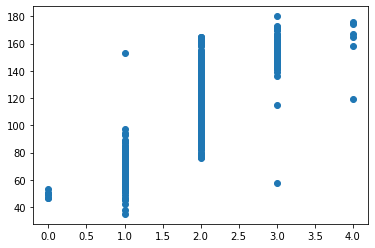

In [ ]:
plt.scatter(df['numeric_age'],df['#Height'])
plt.show()

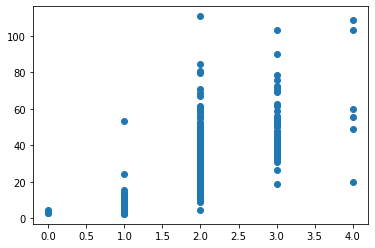

In [ ]:
plt.scatter(df['numeric_age'],df['#Weight'])
plt.show()

Se podrian hasta de quitar esas variables demograficas, o ponerlas como entredas en una etapa final de la red despues de haber procesado las señales.